In [45]:
import numpy as np 
import random
from scipy.optimize import minimize
from sphere_decoding.sphereDecodingUseC import sphere_decoding_BER


# generate transmit signal
def generate_random_bit_sequence(length):
    return ''.join(random.choice('01') for _ in range(length))

def qam16_modulation(binary_input):
    mapping = {
        '0000': (1+1j),
        '0001': (1+3j),
        '0010': (3+1j),
        '0011': (3+3j),
        '0100': (1-1j),
        '0101': (1-3j),
        '0110': (3-1j),
        '0111': (3-3j),
        '1000': (-1+1j),
        '1001': (-1+3j),
        '1010': (-3+1j),
        '1011': (-3+3j),
        '1100': (-1-1j),
        '1101': (-1-3j),
        '1110': (-3-1j),
        '1111': (-3-3j)
    }
    return mapping.get(binary_input, "Invalid binary input")/np.sqrt(10)

def generate_x_sequence(length, Nt):
    total_bits_sequence = generate_random_bit_sequence(length*Nt*4)
    bits_sequence = [total_bits_sequence[i:i+4] for i in range(0, len(total_bits_sequence), 4)]
    x_sequence = [np.array([qam16_modulation(bits_sequence[i+j]) for j in range(Nt)]) for i in range(0, len(bits_sequence), Nt)]
    return bits_sequence, x_sequence

def generate_noise(SNR, Nr):
    return np.sqrt(1/(2*SNR))*(np.random.randn(Nr,1)+1j*np.random.randn(Nr,1))

# generate training and tesing data
def generate_data(Nr,Nt,SNR_dB,length,H_channel):
    bits_sequence, x_sequence = generate_x_sequence(length, Nt)
    SNR= 10**(SNR_dB/10)
    n_sequence = [generate_noise(SNR, Nr) for i in range(length)]
    y_sequence = [np.dot(H_channel, x_sequence[i].reshape(Nt,1)) + n_sequence[i] for i in range(length)]
    return bits_sequence, x_sequence, y_sequence

def bits2signals(bits):
    # bits: input binary string with length of (4*Nt) 
    return np.array([qam16_modulation(bits[i:i+4]) for i in range(0, len(bits), 4)]).reshape(Nt,1)
def calculate_layer1(H_hat, y):
    dimension_layer1 = 2**(4*Nt)
    output = {}
    for index in range(dimension_layer1):
        bits = str(bin(index)[2:].zfill(4*Nt))
        s = bits2signals(bits)
        error = y - np.dot(H_hat,s)
        value =  np.exp(-np.square(np.linalg.norm(error)))
        output[bits] = value
    return output

def calculate_layer2(layer1_output):
    sum_exp = [[0 for i in range(2)] for j in range(4*Nt)]
    for bits in layer1_output:
        value = layer1_output[bits]
        for index in range(4*Nt):
            sum_exp[index][eval(bits[index])] += value
    output = {}
    for index in range(4*Nt):
        # llr = np.log(sum_exp[index][1]/sum_exp[index][0])
        output[index] = (sum_exp[index][1])/(sum_exp[index][1]+sum_exp[index][0])
    return output

def calculate_cross_entropy(layer2_output, true_sequence):
    dimension = len(true_sequence)
    entropy = 0
    for index in range(dimension):
        if true_sequence[index] == '1':
            entropy += (-np.log(layer2_output[index]))
    return entropy

def calculate_square_error(layer2_output, true_sequence):
    dimension = len(true_sequence)
    loss = 0
    for index in range(dimension):
        if true_sequence[index] == '1':
            loss += np.square(1-layer2_output[index])
        else:
            loss += np.square(layer2_output[index])
    return loss

def calculate_cost_function(H_hat_vec):
    H_hat = H_hat_vec[0:Nr*Nt].reshape(Nr,Nt)+1j*H_hat_vec[Nr*Nt:2*Nr*Nt].reshape(Nr,Nt)
    # H_hat = H_hat_vec
    total_loss = 0
    training_length = len(y_sequence)
    for ii in range(training_length):
        layer1_output = calculate_layer1(H_hat, y_sequence[ii])
        layer2_output = calculate_layer2(layer1_output)
        true_sequence = ''.join(bits_sequence[ii*Nt+jj] for jj in range(Nt))
        total_loss += calculate_square_error(layer2_output,true_sequence)
    mean_loss = total_loss/training_length
    # print(mean_loss)
    return mean_loss
        
def detection(y, H_trained):
    layer1_output = calculate_layer1(H_trained, y)
    layer2_output = calculate_layer2(layer1_output)
    detect_result = ''
    for ii in range(len(layer2_output)):
        if(layer2_output[ii]>0.5):
            detect_result += '1'
        else:
            detect_result += '0'
    return(detect_result)

def count_differences(str1, str2):
    return sum(a != b for a, b in zip(str1, str2))


def training():
    H_hat_vec = np.sqrt(1/2)*(np.random.randn(Nr*Nt*2))

    out = minimize(calculate_cost_function, x0=H_hat_vec, method="COBYLA", options={'maxiter':100})

    H_hat_vec = out.x

    H_trained = H_hat_vec[0:Nr*Nt].reshape(Nr,Nt)+1j*H_hat_vec[Nr*Nt:2*Nr*Nt].reshape(Nr,Nt)
    
    return H_trained

def calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing):
    error = 0
    for ii in range(len(y_sequence_testing)):
        detect_result = detection(y_sequence_testing[ii], H_trained)
        true_sequence = ''.join(bits_sequence_testing[ii*Nt+jj] for jj in range(Nt))
        error += count_differences(detect_result, true_sequence)
    BER = error/(len(y_sequence_testing)*len(detect_result))
    return BER


# generate training and tesing data
Nt = 2
Nr = 4
# generate channel

iter_num = 3
SNR_list = np.array([0, 5, 10, 15, 20])

SD_mean_performance = np.zeros(len(SNR_list))
QNN_mean_performance = np.zeros(len(SNR_list))

H_list = [np.sqrt(1/2)*(np.random.randn(Nr,Nt)+1j*np.random.randn(Nr,Nt)) for ii in range(iter_num)]

for ii in range(len(SNR_list)):
    SNR_dB = SNR_list[ii]
    print("SNR_dB: "+str(SNR_dB))
    
    SD_performance = np.zeros(iter_num)
    QNN_performance = np.zeros(iter_num)

    for jj in range(iter_num):
        # print("current iter num: " +str(jj))
        H = H_list[jj]
        # print(H)
        bits_sequence_testing, x_sequence_testing, y_sequence_testing = generate_data(Nr,Nt,SNR_dB,1024,H)
        SD_performance[jj] = sphere_decoding_BER(H, y_sequence_testing, bits_sequence_testing, 0.1)
        print("SD: "+str(SD_performance[jj]))

        bits_sequence, x_sequence, y_sequence = generate_data(Nr,Nt,SNR_dB,128,H)
        H_trained = training()
        QNN_performance[jj] = calculate_BER(H_trained, bits_sequence_testing, y_sequence_testing)
        print("QNN: "+str(QNN_performance[jj]))

    SD_mean_performance[ii] = np.mean(SD_performance)
    QNN_mean_performance[ii] = np.mean(QNN_performance)

print(SD_mean_performance)
print(QNN_mean_performance)

SNR_dB: 0
SD: 0.001953125
QNN: 0.2027587890625
SD: 0.001953125
QNN: 0.1661376953125
SD: 0.004638671875
QNN: 0.318603515625
SNR_dB: 5
SD: 0.0010986328125
QNN: 0.1102294921875
SD: 0.00146484375
QNN: 0.0797119140625
SD: 0.0106201171875
QNN: 0.2960205078125
SNR_dB: 10
SD: 0.00048828125
QNN: 0.0743408203125
SD: 0.0010986328125
QNN: 0.32763671875
SD: 0.005615234375
QNN: 0.14697265625
SNR_dB: 15
SD: 0.0
QNN: 0.342041015625
SD: 0.0
QNN: 0.0020751953125
SD: 0.0010986328125
QNN: 0.2205810546875
SNR_dB: 20
SD: 0.0
QNN: 0.0518798828125
SD: 0.0
QNN: 0.1295166015625
SD: 0.0
QNN: 0.1925048828125
[0.00284831 0.00439453 0.00240072 0.00036621 0.        ]
[0.22916667 0.1619873  0.1829834  0.18823242 0.12463379]


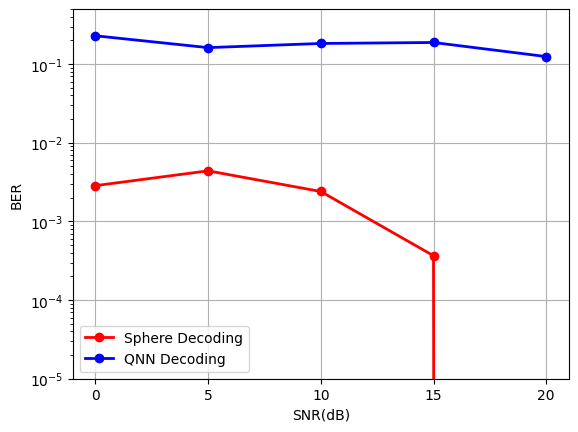

In [47]:
import matplotlib.pyplot as plt
fig = plt.figure()

ax1 = fig.add_subplot(111)

lns1 = ax1.plot(SNR_list, SD_mean_performance, '-ro', linewidth=2.0, label="Sphere Decoding")
lns2 = ax1.plot(SNR_list, QNN_mean_performance, '-bo', linewidth=2.0, label="QNN Decoding")

lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc="lower left")
ax1.grid()

ax1.set_xticks(SNR_list)
ax1.set_yscale("log")
ax1.set_adjustable("datalim")
ax1.set_ylim(1e-5, 0.5)
ax1.set_ylabel("BER")
ax1.set_xlabel("SNR(dB)")


# plt.savefig('convergence.pdf',dpi=600, bbox_inches='tight')
plt.show()